This example examines output from the `hasegawa-wakatani` example included in
the `BOUT-dev` repo. \[It was tested with output from the `next` branch at
commit df74b7a92fd3f5ee9ab33e64c5a7739e78e3c57d.\]

`hasegawa-wakatani` is a simple 2d model for plasma motion in the plane
perpendicular to the magnetic field. It produces turbulence.

You can use it in two ways, either generate the data or download it. Generate
by copying `BOUT.inp` from here (the input file was modified to increase the
length of the simulation to get more developed turbulence) to
`BOUT-dev/examples/hasegawa-wakatani/data/BOUT.inp` then running the
`BOUT-dev/examples/hasegawa-wakatani` example and copying the output
`data/BOUT.dmp.*.nc` files to this directory. Download by running the first
Python cell in the 'Setup' section.

Contents:
* Setup
* Load
* Plot
* Animate

Setup
=====

In [1]:
# Download data files if you do not have them already
from pathlib import Path
import urllib.request
if not Path("BOUT.dmp.0.nc").exists():
    urllib.request.urlretrieve(f"https://zenodo.org/record/4304961/files/BOUT.dmp.0.nc?download=1", "BOUT.dmp.0.nc")

In [2]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 14})

In [3]:
import numpy as np
from xbout import open_boutdataset

Load
====

First we need to open the Dataset.

The chunks argument to `open_boutdataset()` is needed so that dask can parallelise
operations over the time dimension (by default the chunk size is the size of the
arrays in the files being loaded). See
http://xarray.pydata.org/en/stable/dask.html#chunking-and-performance.

Note: a warning from `open_boutdataset()` is expected. For `hasegawa-wakatani` the
z-direction is a periodic, binormal direction with lengths normalised to the
background hybrid gyro-radius `rho_s=sqrt(T_e/m_i)`, rather than the usual toroidal
angle. `'dz'` is used and `'ZMIN'` and `'ZMAX'` are ignored.

In [4]:
ds = open_boutdataset(chunks={"t": 4})

# Use squeeze() to get rid of the y-dimension, which has length 1 as
# hasegawa-wakatani does not simulate the parallel dimension.
ds = ds.squeeze(drop=True)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset>
Dimensions:   (x: 260, y: 1, t: 65, z: 256)
Coordinates:
    dx        (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    dy        (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    dz        float64 ...
  * t         (t) float64 0.0 10.0 20.0 30.0 40.0 ... 610.0 620.0 630.0 640.0
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 252 253 254 255 256 257 258 259
  * y         (y) float64 0.5
  * z         (z) float64 0.0 0.2 0.4 0.6 0.8 1.0 ... 50.2 50.4 50.6 50.8 51.0
Data variables: (12/23)
    g11       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g22       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g33       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g12       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g13       (x, y) float64 dask.array<chunksize=(260, 1), meta=np.ndarray>
    g23       (x, y) float64 dask

/home/john/soltransport/pylib/xbout/xbout/load.py:349: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")
/home/john/soltransport/pylib/xbout/xbout/geometries.py:226: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
array(51.2)
Attributes:
    metadata:  {'BOUT_VERSION': 5.0, 'iteration': 63, 'zperiod': 1, 'MXSUB': ...
    options:   None
    geometry:   is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(


We choose to create a 'coordinate' for the x-dimension from `dx`.
This is not done generically because `dx` can have two-dimensional dependence
\- as well as varying radially it can be different e.g. in core and PF regions.
However, for a slab geometry like `hasegawa-wakatani`, `dx` is a constant so it
can easily be used to create a one-dimensional x-coordinate.
This ensures we get a sensible aspect ratio in plots.
A z-coordinate was already created from `dz`, because `dz` is always a scalar,
so it can always be used to create a 1d 'dimension coordinate'.

In [5]:
dx = ds["dx"].isel(x=0).values

# Get rid of existing "x" coordinate, which is just the index values.
ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

Plot
===

Here we use xarray methods to plot simple slices of last time-point of the simulation.

In [6]:
ds_final = ds.isel(t=-1)

<IPython.core.display.Javascript object>


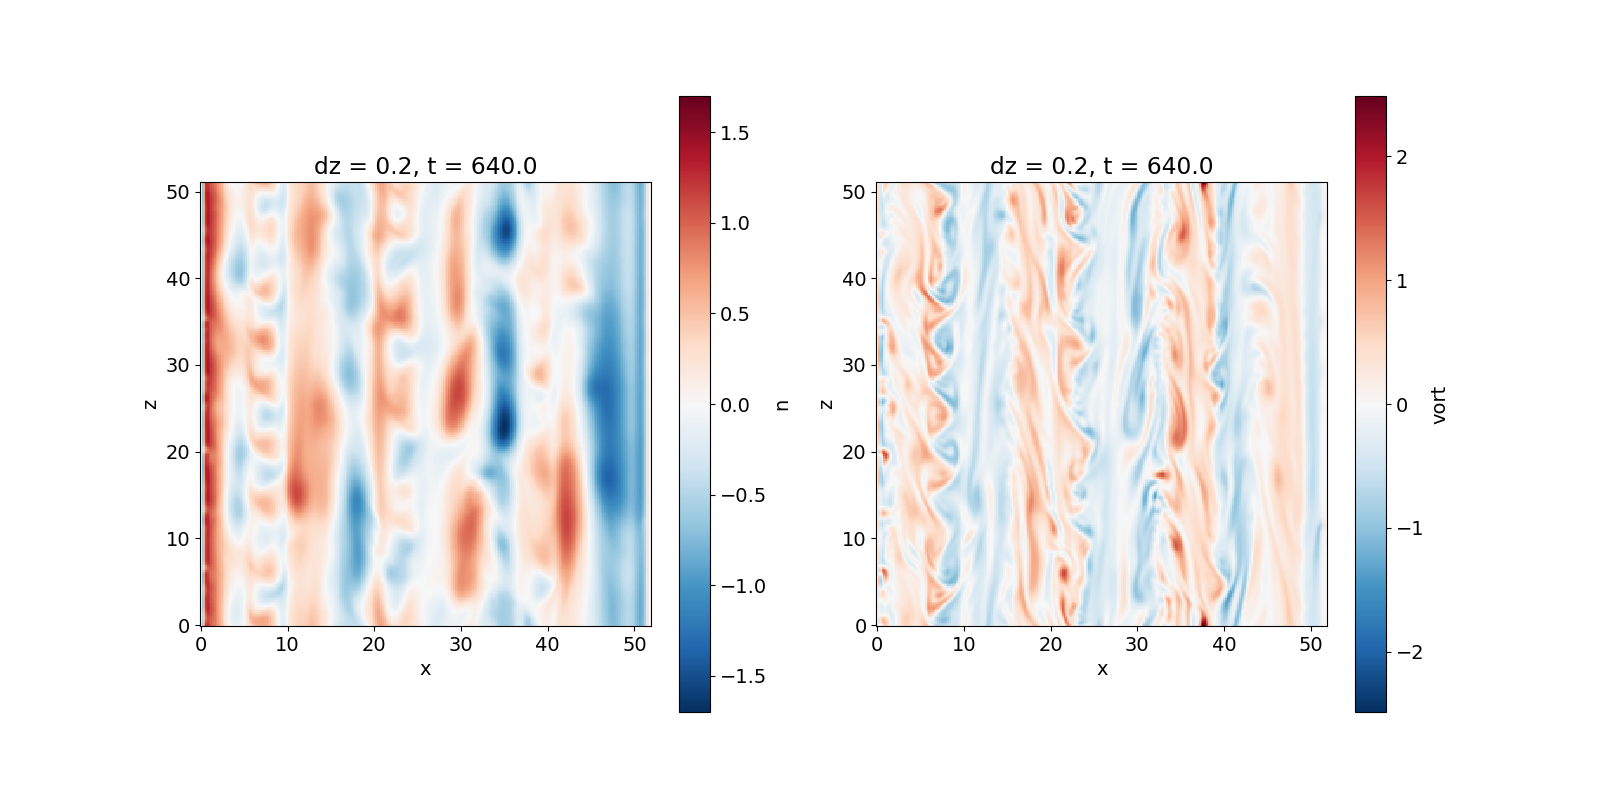

In [7]:
plt.figure()
ax = plt.subplot(121)
ax.set_aspect("equal")
ds_final["n"].plot(x="x", y="z")
ax = plt.subplot(122)
ax.set_aspect("equal")
ds_final["vort"].plot(x="x", y="z")

Animate
=======

Use `xbout` methods through the `.bout` accessor to create animations.

Animate more than one field from a Dataset with `animate_list()`

<IPython.core.display.Javascript object>


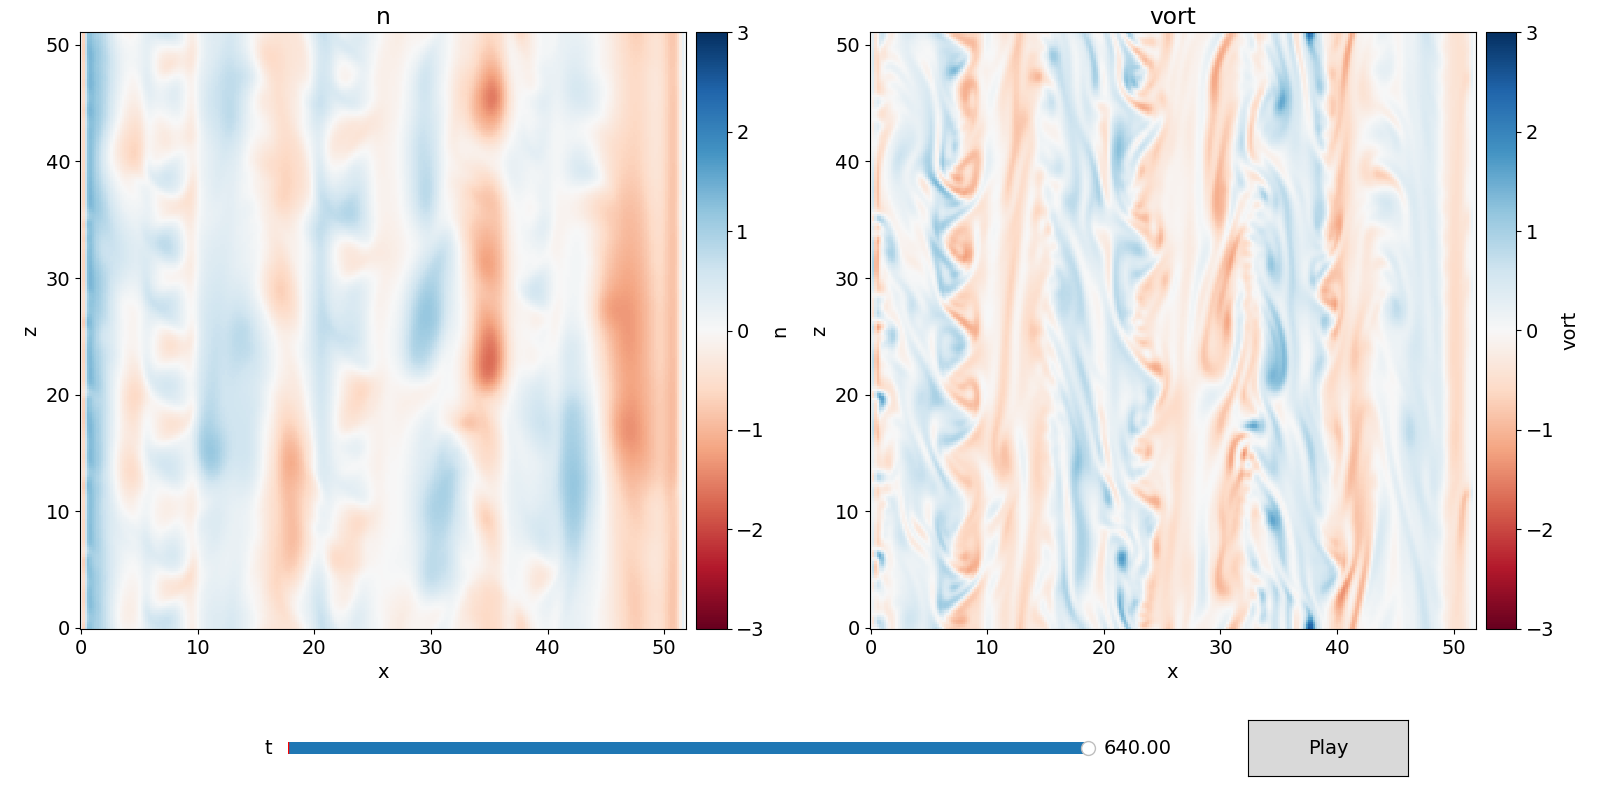

In [8]:
ds.bout.animate_list(["n", "vort"], aspect="equal", cmap="RdBu", vmin=-3, vmax=3)